# U-Net and image segmentation

This notebook is an introduction to image segmentation and more especially the U-Net neural network. It includes case studies with dataset available in the dataset repo aswell as the already trained models in the trained_model repo.

0. [Requirements and import](#sec0)
1. [Introduction to image segmentation](#sec1)
2. [The U-Net network and its specifications](#sec2)
3. [A simple case study](#sec3)
4. [A case study on a more complex dataset](#sec4)
5. [Conclusion](#sec5)


# <a id="sec0">0. Requirements and import</a>

In this notebook we will be using `pytorch` and `torchvision`. We will also be using common libraries such as `numpy` or `matplotlib`.

<div class="alert alert-success">
Exercise 1:
Install the necessary packages and verify that everything is working by importing everything.
</div>

In [23]:
#!pip install -r requirements.txt

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os,sys
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from functools import reduce
from torch.autograd import Variable
import itertools
import tifffile

# <a id="sec1">1. Introduction to image segmentation</a>

The image segmentation purpose is to label the pixels of a picture and thus recognize a certain amount of classes in it: the differents pixel having similar attributes are grouped. There are 2 possible types of image segmentation: semantic segmentation and instance segmentation.

In Semantic Segmentation we label each pixel of an image with a corresponding class of what is being represented
<img src="pictures/semantic_segmentation.png">

Instance Segmentation is one step ahead: each instance of a class is classified separatly

<img src="pictures/instance_segmentation.png">

The output of such tasks are not just labels or bounding box parameters but a high resolution image of usually the same size as the input image

# <a id="sec2">2. The U-Net network and its specifications</a>

U-Net is a massively used neural network for image segmentation, the original paper introducing U-Net has been published in 2015. In this paper U-Net was used for a competition (ISBI challenge 2015 and ISBI challenge 2012) which goal was to track cells/neural structures on a dataset of medical images, it showed impressive results.
<img src="pictures/unet_exemple.png">

Usually neural networks need a very large amount of data, in the medical area such dataset aren't always available. U-Net doesn't need that much data to be competitive, the use of transformation for data augmentation works perfectly fine. It also allows the network to learn invariance to these deformations.

Here is the original structure of the network as introduced in the paper in 2015:
<img src="pictures/unet_structure.png">

The left side of the network (the "contractive" path or "encoder") allows the network to contextualize, the size of the image gradually reduces while the depth gradually increases: basically the networks learn the "what" information but loses the "where" information. The right side of the network (the "extensive" path or "decoder") allows the locate precisely the information, the size of the image gradually increases and the depth gradually decreases: the decoder recovers the "where" information by gradually upsampling. To get better location, at every step of the decoder we use skip connections by concatenating the output of the transposed convolution layers with the feature maps from the Encoder at the same level, a double convolution is then applied.

# <a id="sec3">3. A simple case study</a>

For this part I used the code from : https://github.com/usuyama/pytorch-unet

## Data generation and creation of data loader

We will generate geometrical shapes and train the network to recognize these shapes

In [2]:
def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
        add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)

In [3]:
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

def plot_side_by_side(img_arrays):
# Allows to plot a set of images and their masks side by side
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

def masks_to_colorimg(masks):
# Allows to map each different classes (geometrical shapes) to each color
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

In [4]:
# Generate some random images
input_images, target_masks = generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


<div class="alert alert-success">
Exercise 2:
Using plot_side_by_side(), plot the different images and masks previously created.
</div>

In [1]:
# %load solutions/ex2.py

We will now generate the dataset and create the data loader. Here we don't need any specific transformation or deformation for data augmentation

In [6]:
class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])
0.0 1.0 0.022927517 0.14967239
0.0 1.0 0.004650065 0.06803273


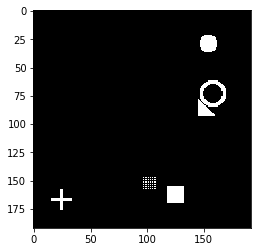

In [7]:
def reverse_transform(inp):
#from tensor to numpy array
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

## Creation of the U-Net model

<div class="alert alert-success">
Exercise 3:
Fill the void using the U-Net network structure previously seen. The network here goes a little less deep than the one from the paper.
</div>

In [8]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, ?? )
        self.dconv_down2 = double_conv(??, ??)
        self.dconv_down3 = double_conv(??, ??)
        self.dconv_down4 = double_conv(??, ??)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(?? + 512, 256)
        self.dconv_up2 = double_conv(?? + 256, 128)
        self.dconv_up1 = double_conv(?? + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

SyntaxError: invalid syntax (<ipython-input-8-6c49385ae2ec>, line 15)

In [2]:
# %load solutions/ex3.py

In [11]:
# we are using there if available, the GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(6)
model = model.to(device)

print(model)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

We define here the different loss functions, the loss used during the training for backpropragation is a balance between the Dice loss and the BCE with logits loss 

In [12]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [13]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### don't launch the training unless you got ~1h30min to lose

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

# Uncomment to launch training
# model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0


Let's load the pre trained model instead ! If the previous cell printed cpu don't run the 2 next cells, you can see the result directly on the picture, if it printed 0 go ahead !

In [17]:
# path = F"trained_model/Unet_geomform.pt"
# model.load_state_dict(torch.load(path))

Let's see how our models perform 

In [18]:
# model.eval()   # Set model to evaluate mode

# test_dataset = SimDataset(10, transform = trans)
# test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=0)
        
# inputs, labels = next(iter(test_loader))
# inputs = inputs.to(device)
# labels = labels.to(device)

# pred = model(inputs)

# pred = pred.data.cpu().numpy()
# print(pred.shape)

# # Change channel-order and make 3 channels for matplot
# input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# # Map each channel (i.e. class) to each color
# target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
# pred_rgb = [masks_to_colorimg(x) for x in pred]

# plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

here is the result if you can't run the previous cells. On the left the input image, in the center the target mask and on the right the prediction 
<img src="pictures/result1.png">

Pretty good isn't it ? We can see that most of the geometrical shapes are well recognized

# <a id="sec4">4. A case study on a more complex dataset</a>

Geometrical shapes are good but let's now work on a more complex dataset. We will see the use of Unet directly on the dataset from the ISBI challenge 2012 !
Let's load the data

In [20]:
class ISBI2012Dataset(Dataset):
    
    def __init__(self, path_img, path_target, transforms=None):
        self.train = np.expand_dims(tifffile.TiffFile(path_img).asarray(), axis=-1)
        self.targets = np.expand_dims(tifffile.TiffFile(path_target).asarray(), axis=-1)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.train)
    
    def __getitem__(self, idx):
        img = self.train[idx]
        target = self.targets[idx]
        
        if self.transforms:
            img = self.transforms(img)
            target = self.transforms(target)
            
        return img, target

In [21]:
transform = transforms.Compose([transforms.ToTensor()])
isbi = ISBI2012Dataset('./dataset/train-volume.tif', './dataset/train-labels.tif',
                       transforms=transform)

In [22]:
print(isbi.train.shape)
print(isbi.targets.shape)

(30, 512, 512, 1)
(30, 512, 512, 1)


<div class="alert alert-success">
Exercise 4:
print the images, take a look at the data
</div>

In [3]:
# %load solutions/ex4.1.py

In [4]:
# %load solutions/ex4.2.py

## Creation of the U-Net model

The model is here almost the same, we just add some BatchNorm2D and change the in channel size for the first conv and the number of classes detected.

In [25]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm(x)
        x = F.relu(self.conv2(x))
        x = self.batch_norm(x)
        return x

In [26]:
class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv1 = Conv(1, 32)
        self.conv2 = Conv(32, 64)
        self.conv3 = Conv(64, 128)
        self.conv4 = Conv(128, 256)
        
        self.conv5 = Conv(256, 512)
        
        self.conv6 = Conv(768, 256)
        self.conv7 = Conv(384, 128)
        self.conv8 = Conv(192, 64)
        self.conv9 = Conv(96, 32)
        
        self.conv10 = nn.Conv2d(32, 1, 1)
        
    def forward(self, x):
        c1 = self.conv1(x)
        x = self.pool1(c1)
        c2 = self.conv2(x)
        x = self.pool2(c2)
        c3 = self.conv3(x)
        x = self.pool3(c3)
        c4 = self.conv4(x)
        x = self.pool4(c4)
        x = self.conv5(x)
        x = self.up1(x)
        x = torch.cat([x, c4], 1)
        x = self.conv6(x)
        x = self.up2(x)
        x = torch.cat([x, c3], 1)
        x = self.conv7(x)
        x = self.up3(x)
        x = torch.cat([x, c2], 1)
        x = self.conv8(x)
        x = self.up4(x)
        x = torch.cat([x, c1], 1)
        x = self.conv9(x)
        x = self.conv10(x)
        return x

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet2()
model = model.to(device)

print(model)

UNet2(
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (up3): Upsample(scale_factor=2.0, mode=nearest)
  (up4): Upsample(scale_factor=2.0, mode=nearest)
  (conv1): Conv(
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Conv(
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1,

We once again define the trainer (we eventually could've adapted the previously used trainer). We here use only the BCE with logits loss criterion. 

In [28]:
class Trainer:
    
    def __init__(self, model):
        self.model = model

    def fit_generator(self, dataset, criterion, optimizer, n_epochs=1, batch_size=1, shuffle=False):
        loss_history = []
                
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        
        for epoch in range(n_epochs):
            running_loss = 0.0
            
            print('Epoch : {}/{}'.format(epoch + 1, n_epochs))
            print('-'*10)
            
            for batch, (data, target) in enumerate(loader):
                data, target = Variable(data.cuda()), Variable(target.cuda())
                
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
                
                if (batch % 10) == 9:
                    print('\tBatch : {}/{}\tLoss : {:.4f}'.format(batch+1, len(loader), loss.item()))
                
                loss.backward()
                optimizer.step()
            
            loss_history.append(running_loss/len(loader))
        return loss_history

    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        x = Variable(x.unsqueeze(0).cuda())
        output = F.sigmoid(self.model(x)).data.cpu()
        return output.numpy()

    def predict_generator(self, dataset, batch_size=1):
        predictions = []
        loader = DataLoader(dataset, batch_size=batch_size)
        for batch, (data, target) in enumerate(loader):
            data = Variable(data.cuda())
            outputs = self.model(data)
            for prediction in outputs:
                predictions.append(F.sigmoid(prediction).data.cpu().numpy())
        return np.array(predictions)

In [29]:
trainer = Trainer(model)

### Don't launch the training unless you got ~30min to lose

In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Uncomment to launch training
# loss_history = trainer.fit_generator(isbi, criterion, optimizer, 25);

In [34]:
print(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

cuda:0


Let's load the pre trained model instead ! If the previous cell printed cpu don't run the commented cells, you can see the result directly on the different pictures 

In [31]:
# path = F"trained_model/UNet_originalDataSet.pt" 
# model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

<All keys matched successfully>

Here is the loss history that we obtain after training
<img src="pictures/loss_history.png">

In [43]:
#img, target = isbi[0]
#y_pred = trainer.predict(img)

In [45]:
#y_pred

array([[[[0.9601518 , 0.9820613 , 0.98728603, ..., 0.99326986,
          0.9900733 , 0.9752906 ],
         [0.98018205, 0.9909508 , 0.99324495, ..., 0.9953069 ,
          0.9944476 , 0.989369  ],
         [0.9853477 , 0.9936807 , 0.99524105, ..., 0.9965166 ,
          0.9956735 , 0.993378  ],
         ...,
         [0.9904108 , 0.9965064 , 0.99744546, ..., 0.9959915 ,
          0.9936532 , 0.9911857 ],
         [0.98589027, 0.9942198 , 0.9959027 , ..., 0.9945304 ,
          0.9925097 , 0.9852701 ],
         [0.9658562 , 0.9867771 , 0.989655  , ..., 0.98986965,
          0.98605806, 0.9708689 ]]]], dtype=float32)

In [44]:
#lt.imshow(y_pred.reshape(512, 512), cmap='gray');

<img src="pictures/figure2.png">

it looks good but it's a little blurry, let's fix that

In [58]:
# thresh = 0.5
# y_pred[y_pred >= thresh] = 1
# y_pred[y_pred < thresh] = 0
# y_pred

In [59]:
# plt.imshow(y_pred.reshape(512, 512), cmap='gray');

<img src="pictures/pic3.png">

And here is the target

In [52]:
#plt.imshow(target.numpy().reshape(512, 512), cmap='gray');

<img src="pictures/figure4.png">

# <a id="sec5">5. Conclusion</a>

We have seeb the application of two simple U-Net networks on two different datasets. Different things could be improved. On the first dataset we could change the data generator so we got a random number of random geometrical shapes instead of always the 6 same shapes. It would add some more challenge for the model. 
Secondly we haven't used data augmentation for the second dataset, it would probably lead to a better result but the training time would be also widely increased